# Motivation

Depending on the noise characteristics, detrending light curves before searching for transits degrades their signal-to-noise-ratio and makes them undetectable. 

Let's show an example of that by generating a light curve containing a periodic transit signal and some correlated noise

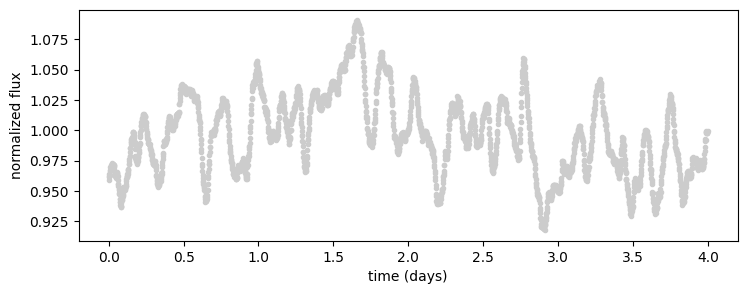

In [1]:
import tinygp
from nuance.utils import simulated
import matplotlib.pyplot as plt

true = dict(t0=0.2, depth=1.5e-2, D=0.05, P=0.7)
(time, flux, error), X, gp = simulated(
    kernel=tinygp.kernels.quasisep.Matern32(sigma=3e-2, scale=true["D"]), **true
)

plt.figure(figsize=(8.5, 3))
plt.plot(time, flux, ".", c="0.8")
plt.xlabel("time (days)")
_ = plt.ylabel("normalized flux")

## Detrending

```{note}
The following requires the installation of the following packages:
- [*wotan*]()
- [*astropy*]()
```

We will now detrend the light curve using Tukey's bi-weight filter, with an optimal window length 3 times that of the transit duration (see [Hippke et al. (2014)]()).

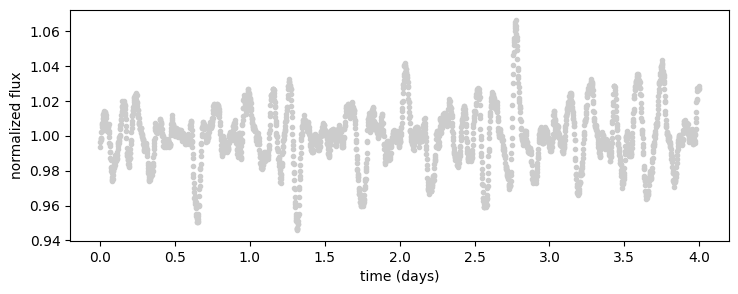

In [2]:
import wotan

detrended_flux = wotan.flatten(
    time, flux, method="biweight", window_length=3 * true["D"]
)

plt.figure(figsize=(8.5, 3))
plt.plot(time, detrended_flux, ".", c="0.8")
plt.xlabel("time (days)")
_ = plt.ylabel("normalized flux")

That doesn't look great. We might be tempted to use a smaller `window_length`, but we will take the risk of detrending part of the transit itself.

## BLS

Let's try to run the [Box-Least-Squares](https://docs.astropy.org/en/stable/timeseries/bls.html) algorithm ([Kovacs et al. 2022](arXiv:astro-ph/0206099)) on the detrended flux.

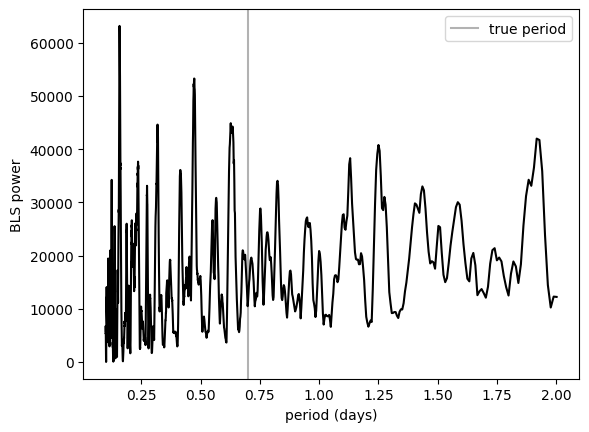

In [3]:
from astropy.timeseries import BoxLeastSquares


def bls(time, flux, error, objective=None):
    model = BoxLeastSquares(time, flux, dy=error)
    periodogram = model.autopower(true["D"], objective=objective)
    periods = periodogram.period
    power = periodogram.power
    return periods, power


periods, snr = bls(time, detrended_flux, error)

plt.plot(periods, snr, "k")
plt.axvline(true["P"], color="k", alpha=0.3, label="true period")
plt.legend()
plt.xlabel("period (days)")
_ = plt.ylabel("BLS power")

As might be expected, we miss the true signal. In order to detrend the light curve in the least-destructive way, let's try different window lengths

In [4]:
import numpy as np
from tqdm.auto import tqdm

window_lengths = np.linspace(0.1, 4, 15)
results = {}

for window_length in tqdm(window_lengths):
    detrended_flux = (
        wotan.flatten(time, flux, method="biweight", window_length=window_length) + 1.0
    )
    periods, power = bls(time, detrended_flux, error)

    results[window_length] = {
        "periods": periods,
        "snr": power,
    }

  0%|          | 0/15 [00:00<?, ?it/s]

and see which one gives us the best periodogram

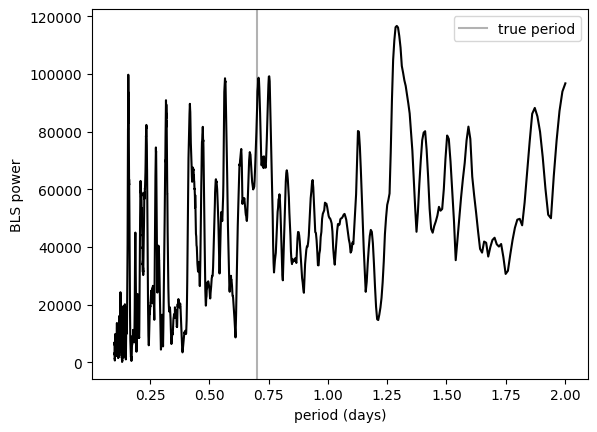

In [5]:
best = max(
    window_lengths, key=lambda window_length: results[window_length]["snr"].max()
)

plt.plot(results[best]["periods"], results[best]["snr"], "k")
plt.axvline(true["P"], color="k", alpha=0.3, label="true period")
plt.legend()
plt.xlabel("period (days)")
_ = plt.ylabel("BLS power")

Not great either. In the [*nuance* paper](https://arxiv.org/abs/2402.06835), we show that, depending on the noise characteristics, many detrending techniques (including using a bi-weight filter) degrade the transit signal-to-noise-ratio up to the point of not being detectable. Before we move on and apply *nuance* to this example, let's try one last method.

# GP detrending

Assuming we have access to the optimal Gaussian Process (GP) kernel that perfectly describes the covariance of the data (we do have access to that here), we can use the original GP used to simulate the light curve to detrend it

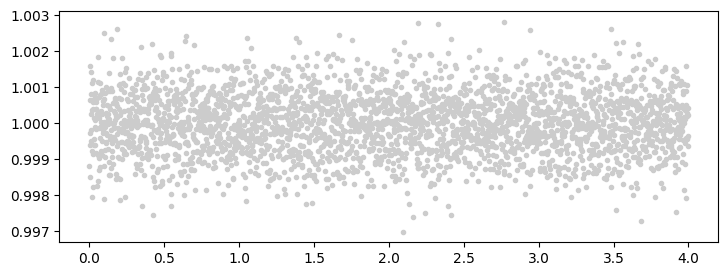

In [6]:
import jax


def trend():
    return gp.condition(flux - 1, time).gp.mean


detrended_flux = flux - jax.jit(trend)()
plt.figure(figsize=(8.5, 3))
_ = plt.plot(time, detrended_flux, ".", c="0.8")

To the eye, it looks like all transits have been removed. Let's check the BLS periodogram

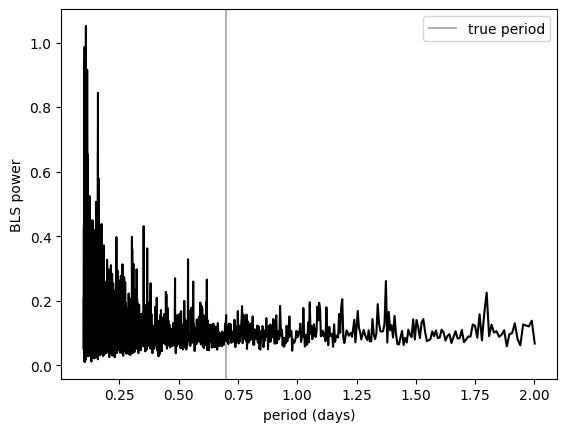

In [7]:
periods, power = bls(time, detrended_flux, error)

plt.plot(periods, power, "k")
plt.axvline(true["P"], color="k", alpha=0.3, label="true period")
plt.legend()
plt.xlabel("period (days)")
_ = plt.ylabel("BLS power")

Not great either.

```{warning}
This is a cherry-picked example 🍒!

Detrending with a Gaussian Process can be great (see [*nuance* paper](https://arxiv.org/abs/2402.06835)) but only assuming you perfectly know the covariance structure of the data, which is never the case.
```

## nuance

Let's now run *nuance* on this simulated dataset. With *nuance*, the transit signal is searched while **simultaneously** modeling correlated noise, assuming that the light curve can be modeled as a Gaussian process.

In [ ]:
from nuance import Nuance

nu = Nuance(time, flux, gp=gp)

The first step of nuance consists in the *linear search* where the likelihood of a single non-periodic transit signal is computed at different epochs and durations

In [9]:
t0s = nu.time.copy()
Ds = np.array([0.01, true["D"]])
nu.linear_search(t0s, Ds)

  0%|          | 0/2880 [00:00<?, ?it/s]

These likelihood are then combined during the *periodic search*

/Users/lgarcia/mambaforge/envs/nuance/lib/python3.11/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3039 [00:00<?, ?it/s]

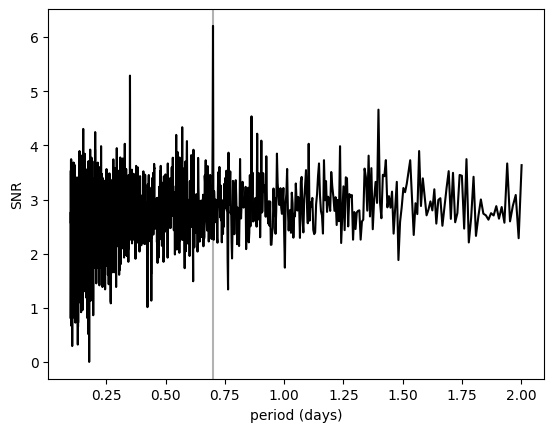

In [10]:
search = nu.periodic_search(periods)

plt.plot(periods, search.Q_snr, "k")
plt.axvline(true["P"], color="k", alpha=0.3, label="true period")
plt.xlabel("period (days)")
_ = plt.ylabel("SNR")

Here *nuance* leads to the successful detection of the true transit signal. Let's plot the found signal against the original one

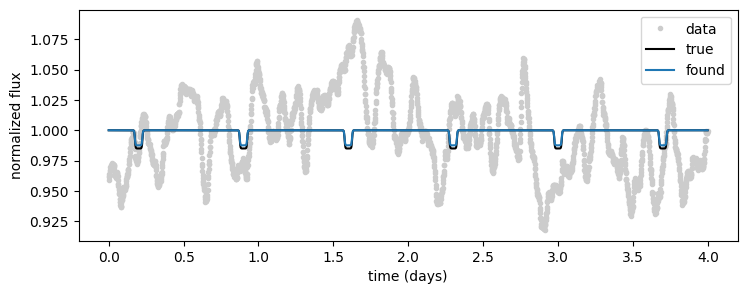

In [11]:
from nuance import core

linear, found, noise = nu.models(*search.best)

true_transit = true["depth"] * core.transit_protopapas(
    time, true["t0"], true["D"], P=true["P"]
)

plt.figure(figsize=(8.5, 3))
plt.plot(time, flux, ".", c="0.8", label="data")
plt.plot(time, true_transit + 1.0, "k", label="true")
plt.plot(time, found + 1.0, "C0", label="found")
plt.legend()
plt.ylabel("normalized flux")
_ = plt.xlabel("time (days)")

```{note}
In this example we employ a perfectly optimal GP kernel. But as we show in the [paper](https://arxiv.org/abs/2402.06835), *nuance* is also robust to non-optimal kernels.
```

```{attention}
*nuance* is not a detrending algorithm and does not produce detrended light curves! What *nuance* does is to compute the likelihood of a transit being present in some correlated noise, **without disentangling the two**.
```